In [2]:
# !pip install hurst
# !pip install rarfile
# !pip install pyunpack
# !pip install patool
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from hurst import compute_Hc
import time
from scipy.stats import skew, kurtosis
import warnings
from sklearn.decomposition import PCA
from scipy.signal import spectrogram
from pyunpack import Archive
import os
import rarfile
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split
from IPython import display
display.set_matplotlib_formats('svg')

warnings.filterwarnings("ignore")


  Obtaining dependency information for rarfile from https://files.pythonhosted.org/packages/75/34/f06b7de74bcea328d8d7a950aad099c1100578cc3960ffc5a00d30ab511c/rarfile-4.1-py3-none-any.whl.metadata


In [14]:
# Ketan's paths
EEG_PATH = '/Users/ketanjaltare1/Desktop/Competitions/hms-harmful-brain-activity-classification/train_eegs/'
SPEC_PATH = '/Users/ketanjaltare1/Desktop/Competitions/hms-harmful-brain-activity-classification/train_spectrograms/'
DIRECTORY = ''

In [ ]:
rar_file_path = "/Users/ketanjaltare1/Desktop/Competitions/hms-harmful-brain-activity-classification/Features_wf_all.part01.rar"
extraction_directory = "/Users/ketanjaltare1/Desktop/Competitions/hms-harmful-brain-activity-classification/Features"

# Ensure the extraction path exists
os.makedirs(extraction_directory, exist_ok=True)
# Extract the .rar file
Archive(rar_file_path).extractall(extraction_directory)

In [ ]:
# Fabien's paths
EEG_PATH = 'D:/Kaggle/2024/Harmful_brain_activity_classification/train_eeg/'
SPEC_PATH = ''
DIRECTORY = 'D:/Kaggle/2024/Harmful_brain_activity_classification/'

In [20]:
# For eeg data
def loadeeg(path):
    eeg = pd.read_parquet(path)
#     eeg = eeg.replace(np.nan, 0) # There are missing values in some files. It makes the PCA analysis fail, so we need to replace them. I have chosen 0 for practicality
    return (eeg)

def hurst_fct(x):
    try:
        out = compute_Hc(x, simplified=True)[0]
    except:
        out = np.nan
    return out
        

In [19]:
# Functions to load a single dataset
train = pd.read_csv(DIRECTORY + 'train.csv')

# dataframe dimensiosn
print(train.shape)
train.head(10)

(106800, 15)


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0
5,1628180742,5,26.0,353733,5,26.0,2413091605,42516,Seizure,3,0,0,0,0,0
6,1628180742,6,30.0,353733,6,30.0,364593930,42516,Seizure,3,0,0,0,0,0
7,1628180742,7,36.0,353733,7,36.0,3811483573,42516,Seizure,3,0,0,0,0,0
8,1628180742,8,40.0,353733,8,40.0,3388718494,42516,Seizure,3,0,0,0,0,0
9,2277392603,0,0.0,924234,0,0.0,1978807404,30539,GPD,0,0,5,0,1,5


In [ ]:
# Samples where there is no consensus
eegids = train.eeg_id.unique()
no_agree = []
for id in eegids:
    temp = train.loc[train.eeg_id == id, 'expert_consensus']
    if len(temp.unique()) > 1:
        no_agree.append(id)
        print(id)
    
print(train.loc[train.eeg_id == no_agree[1],:])

In [101]:
# Try computing synchronisation
from scipy.signal import hilbert
from scipy.signal import iirfilter, filtfilt

# Define your frequency bands as a list of tuples (lowcut, highcut)
frequency_bands = [(1, 4), (4, 8), (8, 12), (12, 30), (30, 95)]  # Example bands in Hz
fs = 200.0  # Sampling frequency
order = 5  # Filter order - This is a trade off in terms of accuracy and time. The lower the faster, but less accurate/narrow
filters = []
b, a = iirfilter(N=order, Wn=1, fs=fs, btype='lowpass', ftype='butter', output='ba')
filters.append((b,a))

for lowcut, highcut in frequency_bands:
    b, a = iirfilter(N=order, Wn=[lowcut, highcut], fs=fs, btype='band', ftype='butter', output='ba')
    filters.append((b,a))    

    
# Function for synchronisation calculation
def compute_synch(filters,data):
    all_synch = np.empty((0, len(filters)))
    for i, (b, a) in enumerate(filters):
        filtered_signal = filtfilt(b, a, data, axis = 0)

        # Calculate the PLV matrix
        try:
            n_points, n_channels, n_reps = filtered_signal.shape # We can change this if we decide to compute on a 2D matrix
        except:
            n_points, n_channels = filtered_signal.shape
            n_reps = 1
            
        plv_matrix = np.zeros((n_channels, n_channels, n_reps))

        # Compute the analytical signal for each channel
        analytical_signals = hilbert(filtered_signal, axis=0)

        # Extract phases
        phases = np.angle(analytical_signals)
        if len(phases.shape) <= 2:
            phases = phases[:,:,np.newaxis]

        # Compute PLV for each pair of channels
        for i in range(n_channels):
            for j in range(i, n_channels):
                phase_diff = phases[:,i,:] - phases[:,j,:]
                plv = np.abs(np.mean(np.exp(1j * phase_diff),axis=0))
                plv_matrix[i, j,:] = plv # Upper triangle of Symmetric matrix
        synch = plv_matrix[np.triu_indices(n_channels,k = 1)].T
        if all_synch.shape[0] == 0:
            all_synch = synch
        else:
            all_synch = np.hstack((all_synch, synch))
        
    return all_synch





def kl_divergence_loss(output, target, epsilon=1e-15):
    # Ensure the output is in log form and target is probabilities
#     log_output = F.log_softmax(output, dim=1)
    
    # Clip target to avoid division by zero or log(0)
    target = torch.clamp(target, epsilon, 1 - epsilon)
    
    # Calculate KL Divergence
    kl_div = target * torch.log(target / torch.exp(target))
    
    # Return mean KL Divergence across the batch
    return kl_div.sum(dim=1).mean()



In [88]:
# Load data for synchronisation computation
time_eeg = np.arange(-25, 25+ (1/200), (1/200))
Starttime = time.time()
labels = train.expert_consensus.unique()
numeegs = 50 # Number of datasets to load from each type
TD_data = {}
Synch_data = np.empty((0,171*len(filters)))
TD_ydata = []
Synch_ydat = np.empty((0,1))
Ydat_KL = np.empty((0,6))


for idx, label in enumerate(labels):
    tempid = train.eeg_id.where(train.expert_consensus == label).unique()
    tempid = tempid[~np.isnan(tempid)] # There were a few nans in there.
    chosen = np.random.choice(tempid,size=numeegs)
    
    for d in range(numeegs):
        path = f'{EEG_PATH}{int(chosen[d])}.parquet'
        fulleeg = loadeeg(path).to_numpy()[:,:19] # Excluding the ECG channel here
        offset = train.eeg_label_offset_seconds[train.eeg_id == chosen[d]].values
        tempdat = np.zeros((len(time_eeg)-1,19,len(offset)))
        tempy = train.loc[train.eeg_id == chosen[d], :].iloc[:, -6:]      #eeg_label_offset_seconds[train.eeg_id == chosen[d]].values
        Ydat_KL = np.vstack((Ydat_KL,tempy))
        for offind, off in enumerate(offset):
            if np.isnan(fulleeg[int(off)*200:(((int(off)+50)*200)),:]).any(): #Not sure why the nans are appearing.
                continue
            tempdat[:,:,offind] = fulleeg[int(off)*200:(((int(off)+50)*200)),:]
            
        TD_data[int(chosen[d])] = tempdat
        TD_ydata.append(label)
        
        Synch_data = np.vstack((Synch_data,compute_synch(filters,tempdat)))
        templabs = np.array([label] * tempdat.shape[2])
        templabs = templabs[:,np.newaxis]
        Synch_ydat = np.vstack((Synch_ydat,templabs))
        
        

TD_keys = list(TD_data.keys())
Ydat_KL = Ydat_KL / np.sum(Ydat_KL,axis=1,keepdims=True)
print(f'Time Taken: {(time.time() - Starttime)/60} minutes for {len(Synch_ydat)} datasets')

Time Taken: 19.503604849179585 minutes for 3178 datasets


[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [90]:
# Step 1: convert to tensor - Only for torch
from sklearn.preprocessing import LabelEncoder

dataT   = torch.tensor( Synch_data ).float()
label_encoder = LabelEncoder()
labelsT = label_encoder.fit_transform(Synch_ydat)
labelsT = torch.tensor( labelsT ).long() # long = int64
labelsT = torch.tensor( Ydat_KL ).float() # long = int64

# Step 2: use scikitlearn to split the data
train_data,test_data, train_labels,test_labels = train_test_split(dataT, labelsT, test_size=.1)


# Step 3: convert into PyTorch Datasets
train_data = TensorDataset(train_data,train_labels)
test_data  = TensorDataset(test_data,test_labels)

# Step 4: translate into dataloader objects
batchsize    = 32
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])


In [91]:

# create a class for the model
def createTheMNISTNet():

  class mnistNet(nn.Module):
    def __init__(self):
      super().__init__()

      ### input layer
      self.input = nn.Linear(Synch_data.shape[1],128)
      
      ### hidden layer
      self.fc1 = nn.Linear(128,200)
      self.fc2 = nn.Linear(200,128)
      self.fc3 = nn.Linear(128,64)

      ### output layer
      self.output = nn.Linear(64,6)

    # forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      x = F.relu( self.fc3(x) )
      return torch.log_softmax( self.output(x),axis=1 )
  
  # create the model instance
  net = mnistNet()
  
  # loss function
#   lossfun = nn.NLLLoss()
  lossfun = nn.KLDivLoss(reduction='batchmean')

  # optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr=.01)

  return net,lossfun,optimizer




# test the model with one batch
net,lossfun,optimizer = createTheMNISTNet()

X, y = next(iter(train_loader))
yHat = net(X)
print(yHat)
# values are log-probability of each number (0-9)
# print(torch.exp(yHat))

# now let's compute the loss
loss = lossfun(yHat,y)
print(' ')
print('Loss:')
print(loss)


tensor([[-1.8395, -1.7607, -1.7320, -1.9039, -1.7293, -1.7967],
        [-1.8394, -1.7606, -1.7323, -1.9040, -1.7303, -1.7955],
        [-1.8392, -1.7626, -1.7342, -1.9034, -1.7308, -1.7915],
        [-1.8406, -1.7561, -1.7362, -1.9038, -1.7322, -1.7927],
        [-1.8409, -1.7562, -1.7343, -1.9034, -1.7338, -1.7932],
        [-1.8416, -1.7568, -1.7353, -1.9050, -1.7284, -1.7952],
        [-1.8421, -1.7561, -1.7330, -1.8998, -1.7328, -1.7978],
        [-1.8405, -1.7605, -1.7304, -1.9021, -1.7294, -1.7991],
        [-1.8378, -1.7572, -1.7335, -1.9021, -1.7353, -1.7955],
        [-1.8402, -1.7559, -1.7343, -1.9038, -1.7346, -1.7930],
        [-1.8409, -1.7590, -1.7330, -1.9018, -1.7310, -1.7961],
        [-1.8430, -1.7560, -1.7352, -1.9008, -1.7307, -1.7961],
        [-1.8393, -1.7600, -1.7328, -1.9030, -1.7305, -1.7963],
        [-1.8414, -1.7619, -1.7297, -1.9030, -1.7332, -1.7928],
        [-1.8382, -1.7610, -1.7349, -1.9014, -1.7317, -1.7942],
        [-1.8394, -1.7601, -1.7335, -1.9

In [92]:


# a function that trains the model

def funtion2trainTheModel():

  # number of epochs
  numepochs = 1000
  
  # create a new model
  net,lossfun,optimizer = createTheMNISTNet()

  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over training data batches
    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)
      

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == torch.argmax(y,axis=1)     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy
    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    X,y = next(iter(test_loader)) # extract X,y from test dataloader
    yHat = net(X)
      
    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==torch.argmax(y,axis=1)).float()) )

  # end epochs

  # function output
  return trainAcc,testAcc,losses,net





# Actually train the model
trainAcc,testAcc,losses,net = funtion2trainTheModel()




## Keras version

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.optimizers import SGD
# from tensorflow.keras.losses import CategoricalCrossentropy
# import tensorflow as tf

# def createTheMNISTNetKeras(input_shape):
#     model = Sequential([
#         Dense(128, activation='relu', input_shape=(input_shape,)),  # Input layer
#         Dense(200, activation='relu'),  # Hidden layer 1
#         Dense(128, activation='relu'),  # Hidden layer 2
#         Dense(64, activation='relu'),   # Hidden layer 3
#         Dense(6, activation='softmax')  # Output layer
#     ])
    
#     # Compile the model
#     model.compile(optimizer=SGD(lr=0.01),
#                   loss=CategoricalCrossentropy(from_logits=True),
#                   metrics=['accuracy'])
    
#     return model

# # Assuming Synch_data.shape[1] provides the input shape
# input_shape = Synch_data.shape[1]  # Replace Synch_data with actual input shape if not defined

# # Create the Keras model
# model = createTheMNISTNetKeras(input_shape)

# # Model summary
# model.summary()

# # You would typically train the model using model.fit() on your dataset.
# # For example:
# # model.fit(X_train, y_train, epochs=10, validation_data=(X_val, y_val))


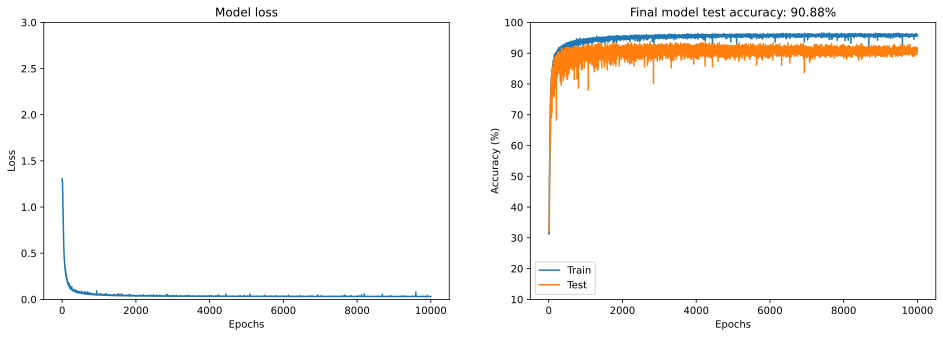

In [93]:

fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_ylim([0,3])
ax[0].set_title('Model loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim([10,100])
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show()

In [102]:
# run the model through for the test data
X,y = next(iter(test_loader))
predictions = net(X).detach()

print(f'The pytorch loss is: {lossfun(predictions,y)}')
print(f'The custom loss is: {kl_divergence_loss(output, target)}')


The pytorch loss is: 0.21974019706249237
The custom loss is: -1.7269389043783612e-13
